In [1]:
import os
import json
import numpy as np
import scipy.stats as ss
import matplotlib
import pylab as plt
from glob import glob
from copy import deepcopy

def filter_by_condi(a, mods, prs, lls, dds, mod=None, pr=None, ll=None, dd=None):
    """
    Filter a matrix of trial data to only get the data from trials that match the specified condition(s)
    :param a: A numpy array with the data from one trial on each row
    :param condi: A list of tuples indicating the list length, presentation rate, modality, distractor duration of each trial
    :param ll: Return only trials with this list length condition (ignore if None)
    :param pr: Return only trials with this presentation rate condition (ignore if None)
    :param mod: Return only trials with this presentation modality condition (ignore if None)
    :param dd: Return only trials with this distractor duration condition (ignore if None
    :return: A numpy array containing only the data from trials that match the specified condition(s)
    """
    if pr == 's':
        pr = 1600
    elif pr == 'f':
        pr = 800
        
    ll = int(ll) if ll is not None else None
    dd = int(dd) if dd is not None else None
    
    ind = [i for i in range(len(a)) if ((ll is None or lls[i] == ll) and (pr is None or prs[i] == pr) and (mod is None or mods[i] == mod) and (dd is None or dds[i] == dd))]
    if len(ind) == 0:
        return np.array([])
    return np.array(a)[ind]

In [2]:
EXCL_WN = True
COLOR = True

excl_str = '_excl_wn' if EXCL_WN else ''
if COLOR:
    VIS_COLOR = '#011F5B' #'C0-'
    AUD_COLOR = '#990000' #'C3-'
    VA_COLOR = '#990000'
    AV_COLOR = '#011F5B'
    VIS_FMT = '-'
    AUD_FMT = '-'
    VA_FMT = '--'
    AV_FMT = '--'
    ERR_ALPHA = .3
    ERR_ALPHA2 = .15
    ERR_ALPHA3 = .1
    VIS_MFC = VIS_COLOR
    AUD_MFC = AUD_COLOR
else:
    VIS_COLOR = 'k'
    AUD_COLOR = 'k'
    VA_COLOR = 'k'
    AV_COLOR = 'k'
    VIS_FMT = '-'
    AUD_FMT = '--'
    VA_FMT = '-.'
    AV_FMT = ':'
    ERR_ALPHA = .2
    ERR_ALPHA2 = .15
    ERR_ALPHA3 = .1
    VIS_MFC = VIS_COLOR
    AUD_MFC = 'w'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 18

plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [3]:
###
# Load statistics and list of participants who wrote notes
###

WN = [s.decode('UTF-8') for s in np.loadtxt('../Data/WROTE_NOTES.txt', dtype='S8')]

with open('../Data/stats/all_v1%s.json' % excl_str, 'r') as f:
    s = json.load(f)

means1 = s['mean']
sems1 = s['sem']
Ns1 = s['N']

with open('../Data/stats/all_v2%s.json' % excl_str, 'r') as f:
    s = json.load(f)

means2 = s['mean']
sems2 = s['sem']
Ns2 = s['N']

In [4]:
subj_files = glob('../Data/stats/MTK[0-9][0-9][0-9][0-9].json')
subj_files = [f for f in subj_files if f[-12:-5] not in WN]

nsubj = len(subj_files)
spc = np.full((nsubj, 24, 2, 2), np.nan)  # Probability of recall for each subj x serialpos x modality x list length
pfr = np.full((nsubj, 24, 2, 2), np.nan)
spc_fr1 = np.full((nsubj, 24, 2, 2), np.nan)
spc_frl4 = np.full((nsubj, 24, 2, 2), np.nan)

for i, path in enumerate(subj_files):
    with open(path, 'r') as f:
        s = json.load(f)
    for j, mod in enumerate(('v', 'a')):
        for k, ll in enumerate(('12', '24')):
            if mod + ll in s['spc']:
                spc[i, :int(ll), j, k] = s['spc'][mod + ll]
                pfr[i, :int(ll), j, k] = s['pfr'][mod + ll]
                spc_fr1[i, :int(ll), j, k] = s['spc_fr1'][mod + ll]
                spc_frl4[i, :int(ll), j, k] = s['spc_frl4'][mod + ll]

# SPC

C:\Users\jpazd\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


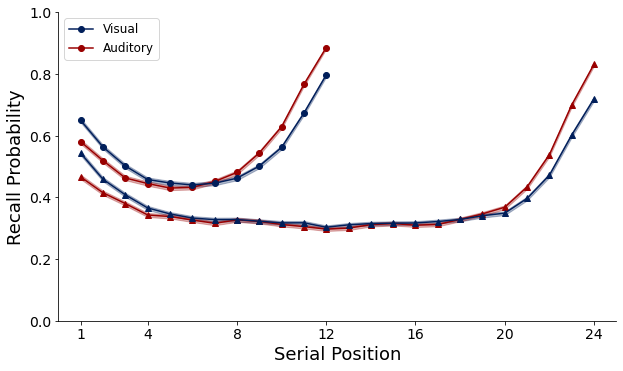

In [5]:
m = np.nanmean(spc, axis=0)
s = ss.sem(spc, axis=0, nan_policy='omit')

plt.plot(range(1, 13), m[:12, 0, 0], VIS_FMT+'o', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 13), m[:12, 0, 0] + s[:12, 0, 0], m[:12, 0, 0] - s[:12, 0, 0], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 13), m[:12, 1, 0], AUD_FMT+'o', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 13), m[:12, 1, 0] + s[:12, 1, 0], m[:12, 1, 0] - s[:12, 1, 0], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 0, 1], VIS_FMT+'^', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 25), m[:, 0, 1] + s[:, 0, 1], m[:, 0, 1] - s[:, 0, 1], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 1, 1], AUD_FMT+'^', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 25), m[:, 1, 1] + s[:, 1, 1], m[:, 1, 1] - s[:, 1, 1], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.legend(labels=['Visual', 'Auditory'], loc=2)
plt.xlabel('Serial Position')
plt.ylabel('Recall Probability')
plt.ylim(0, 1)
plt.xlim(0, 25)
plt.xticks([1, 4, 8, 12, 16, 20, 24])
plt.gcf().set_size_inches(9, 5.5)
plt.tight_layout(w_pad=.5)
plt.savefig('poster_figures/spc.svg')

# PFR

C:\Users\jpazd\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


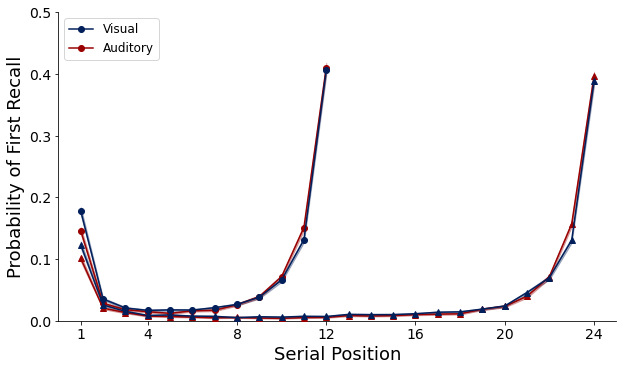

In [6]:
m = np.nanmean(pfr, axis=0)
s = ss.sem(pfr, axis=0, nan_policy='omit')

plt.plot(range(1, 13), m[:12, 0, 0], VIS_FMT+'o', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 13), m[:12, 0, 0] + s[:12, 0, 0], m[:12, 0, 0] - s[:12, 0, 0], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 13), m[:12, 1, 0], AUD_FMT+'o', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 13), m[:12, 1, 0] + s[:12, 1, 0], m[:12, 1, 0] - s[:12, 1, 0], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 0, 1], VIS_FMT+'^', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 25), m[:, 0, 1] + s[:, 0, 1], m[:, 0, 1] - s[:, 0, 1], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 1, 1], AUD_FMT+'^', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 25), m[:, 1, 1] + s[:, 1, 1], m[:, 1, 1] - s[:, 1, 1], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.legend(labels=['Visual', 'Auditory'], loc=2)
plt.xlabel('Serial Position')
plt.ylabel('Probability of First Recall')
plt.ylim(0, .5)
plt.xlim(0, 25)
plt.xticks([1, 4, 8, 12, 16, 20, 24])
plt.gcf().set_size_inches(9, 5.5)
plt.tight_layout(w_pad=.5)
plt.savefig('poster_figures/pfr.svg')

# SPC by Start Position

C:\Users\jpazd\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
C:\Users\jpazd\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


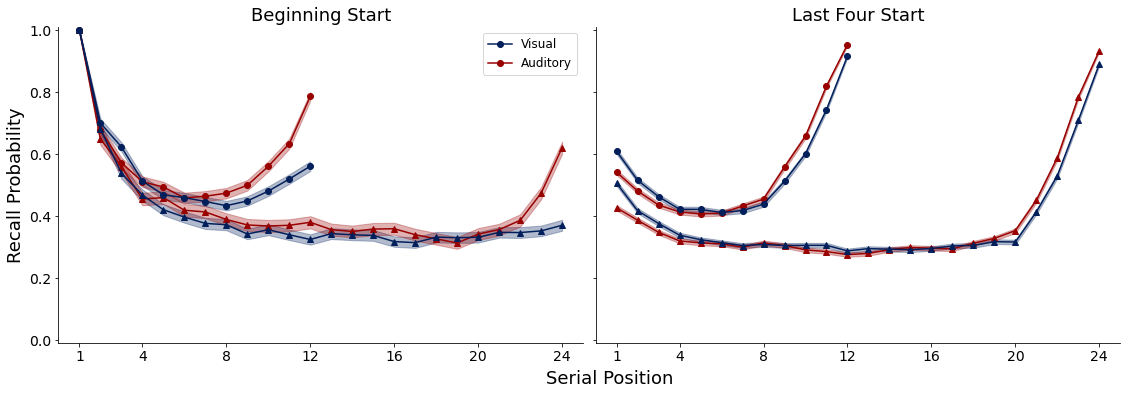

In [7]:
m = np.nanmean(spc_fr1, axis=0)
s = ss.sem(spc_fr1, axis=0, nan_policy='omit')

plt.subplot(121)
plt.plot(range(1, 13), m[:12, 0, 0], VIS_FMT+'o', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 13), m[:12, 0, 0] + s[:12, 0, 0], m[:12, 0, 0] - s[:12, 0, 0], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 13), m[:12, 1, 0], AUD_FMT+'o', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 13), m[:12, 1, 0] + s[:12, 1, 0], m[:12, 1, 0] - s[:12, 1, 0], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 0, 1], VIS_FMT+'^', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 25), m[:, 0, 1] + s[:, 0, 1], m[:, 0, 1] - s[:, 0, 1], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 1, 1], AUD_FMT+'^', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 25), m[:, 1, 1] + s[:, 1, 1], m[:, 1, 1] - s[:, 1, 1], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.legend(labels=['Visual', 'Auditory'])#, loc=2)
plt.title('Beginning Start')
plt.ylabel('Recall Probability')
plt.ylim(-.01, 1.01)
plt.xlim(0, 25)
plt.xticks([1, 4, 8, 12, 16, 20, 24])

m = np.nanmean(spc_frl4, axis=0)
s = ss.sem(spc_frl4, axis=0, nan_policy='omit')

plt.subplot(122)
plt.plot(range(1, 13), m[:12, 0, 0], VIS_FMT+'o', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 13), m[:12, 0, 0] + s[:12, 0, 0], m[:12, 0, 0] - s[:12, 0, 0], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 13), m[:12, 1, 0], AUD_FMT+'o', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 13), m[:12, 1, 0] + s[:12, 1, 0], m[:12, 1, 0] - s[:12, 1, 0], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 0, 1], VIS_FMT+'^', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 25), m[:, 0, 1] + s[:, 0, 1], m[:, 0, 1] - s[:, 0, 1], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 1, 1], AUD_FMT+'^', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 25), m[:, 1, 1] + s[:, 1, 1], m[:, 1, 1] - s[:, 1, 1], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.title('Last Four Start')
plt.ylim(-.01, 1.01)
plt.xlim(0, 25)
plt.xticks([1, 4, 8, 12, 16, 20, 24])
plt.yticks(ticks=[0, .2, .4, .6, .8, 1], labels=[])

plt.gcf().text(0.54, 0.012, 'Serial Position', ha='center', va='center')
plt.gcf().set_size_inches(16, 5.5)
plt.tight_layout(w_pad=.5)
plt.savefig('poster_figures/spc_by_start.svg')

# Prior-List Intrusions

In [8]:
def intrusions(m1, s1, m2, s2, n_points=5):
    
    f, ((sp1, sp2), (sp3, sp4)) = plt.subplots(2, 2, gridspec_kw={'width_ratios':[1, 1.4]})

    m = m1['plis_2factor']
    s = s1['plis_2factor']
    
    sp1.bar([1, 2, 3, 4], [m[0][0], m[1][1], m[0][1], m[1][0]], yerr=[s[0][0]*1.96, s[1][1]*1.96, s[0][1]*1.96, s[1][0]*1.96], color=['w', 'w', 'w', 'w'], edgecolor='k', capsize=3)
    sp1.set_xticks([1, 2, 3, 4])
    sp1.set_xticklabels(('V-V', 'A-A', 'V-A', 'A-V'))
    sp1.set_ylim(0, .125)
    sp1.set_xlabel('Modality')
    sp1.set_ylabel('PLIs per Trial (Exp. 1)')
    sp1.spines['right'].set_visible(False)
    sp1.spines['top'].set_visible(False)
    sp1.yaxis.set_ticks_position('left')
    sp1.xaxis.set_ticks_position('bottom')
    
    m = m2['plis']
    s = s2['plis']
    
    sp3.bar([1, 2], [m['v'], m['a']], yerr=[s['v']*1.96, s['a']*1.96], color=['w', 'w'], edgecolor='k', capsize=3)
    sp3.set_xticks([1, 2])
    sp3.set_xticklabels(('Visual', 'Auditory'))
    sp3.set_ylim(0, .25)
    sp3.set_xlabel('Modality')
    sp3.set_ylabel('PLIs per Trial (Exp. 2)')
    sp3.spines['right'].set_visible(False)
    sp3.spines['top'].set_visible(False)
    sp3.yaxis.set_ticks_position('left')
    sp3.xaxis.set_ticks_position('bottom')
    
    xrange = range(1, 6)
    m = np.array(m1['pli_recency_2factor'])
    s = np.array(s1['pli_recency_2factor'])
    
    sp2.plot(xrange, m[:n_points, 0, 0], VIS_FMT, color=VIS_COLOR)
    sp2.fill_between(xrange, np.add(m[:n_points, 0, 0], s[:n_points, 0, 0]), np.subtract(m[:n_points, 0, 0], s[:n_points, 0, 0]), color=VIS_COLOR, alpha=ERR_ALPHA)
    sp2.plot(xrange, m[:n_points, 0, 1], VA_FMT, color=VA_COLOR)
    sp2.fill_between(xrange, np.add(m[:n_points, 0, 1], s[:n_points, 0, 1]), np.subtract(m[:n_points, 0, 1], s[:n_points, 0, 1]), color=VA_COLOR, alpha=ERR_ALPHA)
    sp2.plot(xrange, m[:n_points, 1, 0], AV_FMT, color=AV_COLOR)
    sp2.fill_between(xrange, np.add(m[:n_points, 1, 0], s[:n_points, 1, 0]), np.subtract(m[:n_points, 1, 0], s[:n_points, 1, 0]), color=AV_COLOR, alpha=ERR_ALPHA)
    sp2.plot(xrange, m[:n_points, 1, 1], AUD_FMT, color=AUD_COLOR)
    sp2.fill_between(xrange, np.add(m[:n_points, 1, 1], s[:n_points, 1, 1]), np.subtract(m[:n_points, 1, 1], s[:n_points, 1, 1]), color=AUD_COLOR, alpha=ERR_ALPHA)
    sp2.legend(labels=['V-V', 'V-A', 'A-V', 'A-A'])
    sp2.set_xlabel('List Recency')
    sp2.set_ylabel('Proportion of PLIs (Exp. 1)')
    sp2.set_xticks(xrange)
    sp2.set_ylim(0, .5)
    sp2.spines['right'].set_visible(False)
    sp2.spines['top'].set_visible(False)
    sp2.yaxis.set_ticks_position('left')
    sp2.xaxis.set_ticks_position('bottom')
    
    m = m2['pli_recency']
    s = s2['pli_recency']
    
    sp4.plot(xrange, m['v'][:n_points], VIS_FMT, color=VIS_COLOR)
    sp4.fill_between(xrange, np.add(m['v'][:n_points], s['v'][:n_points]), np.subtract(m['v'][:n_points], s['v'][:n_points]), color=VIS_COLOR, alpha=ERR_ALPHA)
    sp4.plot(xrange, m['a'][:n_points], AUD_FMT, color=AUD_COLOR)
    sp4.fill_between(xrange, np.add(m['a'][:n_points], s['a'][:n_points]), np.subtract(m['a'][:n_points], s['a'][:n_points]), color=AUD_COLOR, alpha=ERR_ALPHA)
    sp4.legend(labels=['Visual', 'Auditory'])
    sp4.set_xlabel('List Recency')
    sp4.set_ylabel('Proportion of PLIs (Exp. 2)')
    sp4.set_xticks(xrange)
    sp4.set_ylim(0, .5)
    sp4.spines['right'].set_visible(False)
    sp4.spines['top'].set_visible(False)
    sp4.yaxis.set_ticks_position('left')
    sp4.xaxis.set_ticks_position('bottom')
    
    plt.gcf().set_size_inches(12, 10)
    plt.tight_layout(w_pad=.5)

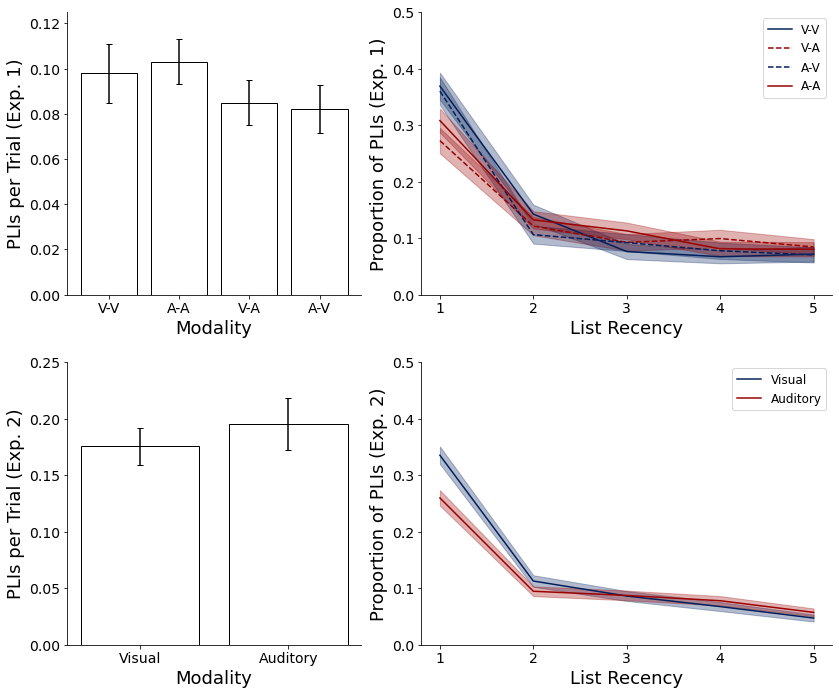

In [9]:
intrusions(means1, sems1, means2, sems2)
plt.savefig('poster_figures/intrusions.svg')